Example from https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
    
Train a simple deep CNN on the CIFAR10 small images dataset.

GPU run command with Theano backend (with TensorFlow, the GPU is automatically used):
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatx=float32 python cifar10_cnn.py

It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).

This seems to fail on model construction when using Theano, so before running, set up Keras to use TensorFlow:

Keras seems to use Theano as backend by default. To change to using TensorFlow, edit ~/.keras/keras.json and replace theano with tensorflow.

Or set environment value: KERAS_BACKEND=tensorflow.

See https://keras.io/backend/

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [3]:
batch_size = 32
num_classes = 10
epochs = 200   # Probably want to stop around 75 but now we have auto-stopping
data_augmentation = False  # True

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


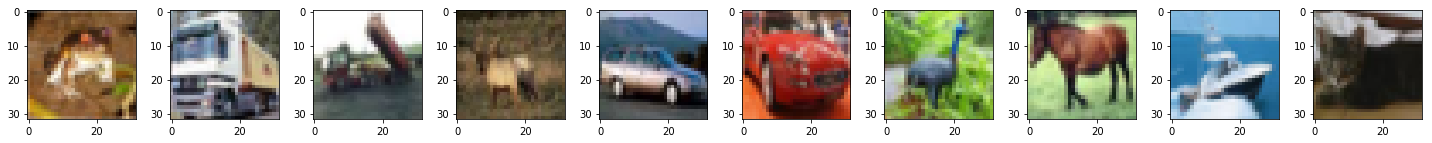

In [5]:
fig, ax = plt.subplots(1, 10, figsize=(20,3))
for i, a in enumerate(ax.flatten()):
    a.imshow(x_train[i])
fig.tight_layout()

Let's see examples from each of the 10 groups.

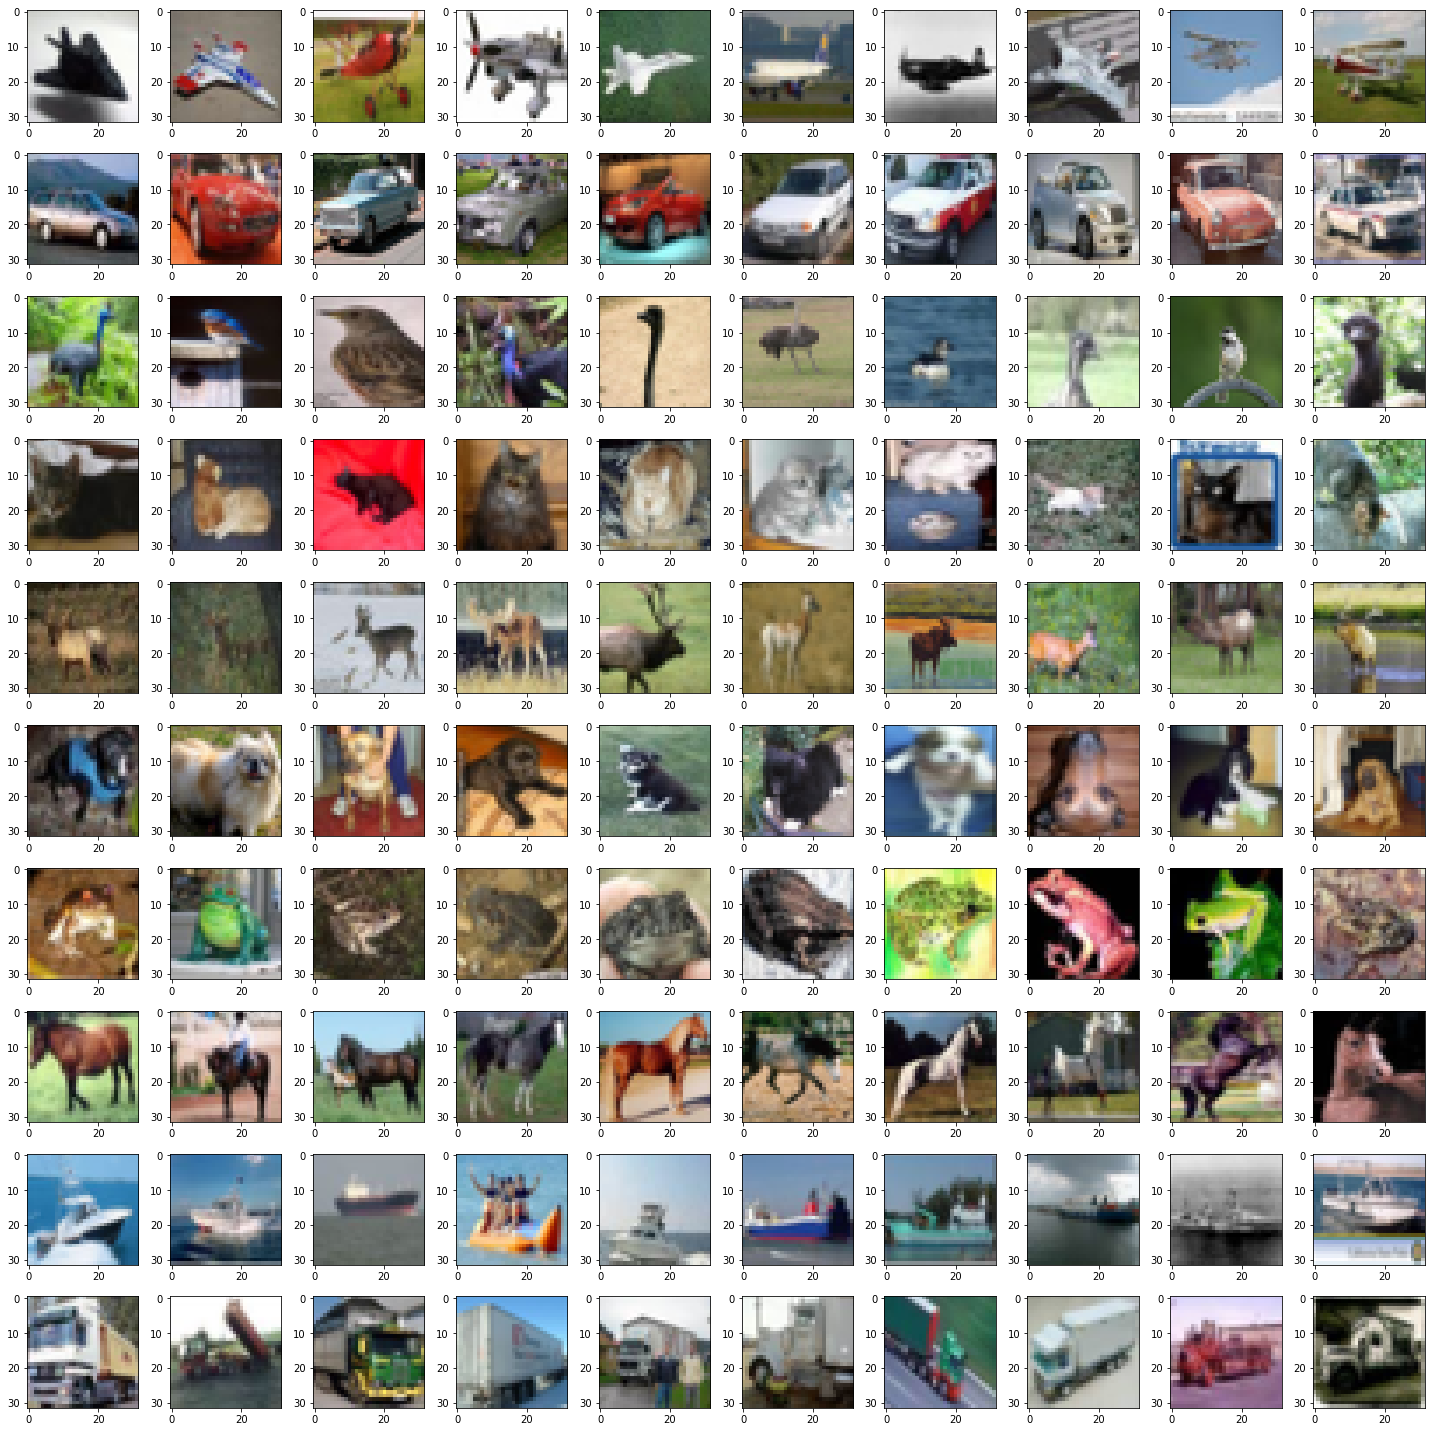

In [6]:
fig, ax = plt.subplots(10, 10, figsize=(20,20))
for i, a in enumerate(ax.flatten()):
    class_ind = i // 10
    pic_ind = i % 10
    group = np.where(y_train.flatten() == class_ind)[0][pic_ind]
    a.imshow(x_train[group])
fig.tight_layout()

In [7]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [9]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [11]:
# Turn off fitting when validation loss is not improving.
# See: https://keras.io/getting-started/faq/#how-can-i-interrupt-training-when-the-validation-loss-isnt-decreasing-anymore

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [12]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          shuffle=True, callbacks=[early_stopping])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test), 
                        callbacks=[early_stopping])

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 54s - loss: 1.7985 - acc: 0.3418 - val_loss: 1.5352 - val_acc: 0.4354
Epoch 2/200
50000/50000 [==============================] - 43s - loss: 1.4799 - acc: 0.4626 - val_loss: 1.3373 - val_acc: 0.5218
Epoch 3/200
50000/50000 [==============================] - 43s - loss: 1.3502 - acc: 0.5158 - val_loss: 1.2497 - val_acc: 0.5501
Epoch 4/200
50000/50000 [==============================] - 43s - loss: 1.2570 - acc: 0.5503 - val_loss: 1.1447 - val_acc: 0.5942
Epoch 5/200
50000/50000 [==============================] - 43s - loss: 1.1785 - acc: 0.5829 - val_loss: 1.0873 - val_acc: 0.6165
Epoch 6/200
50000/50000 [==============================] - 43s - loss: 1.1138 - acc: 0.6110 - val_loss: 1.0510 - val_acc: 0.6333
Epoch 7/200
50000/50000 [==============================] - 43s - loss: 1.0605 - acc: 0.6297 - val_loss: 0.9843 - val_acc: 0.6551
Epoch 8/200
50000/

In [40]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
pred = model.predict_classes(x_test)

10000/10000 [==============================] - 9s     
Test loss: 1.09711257553
Test accuracy: 0.6532
 9952/10000 [============================>.] - ETA: 0s

In [41]:
# Reload the data to compare predictions vs. actual on test data:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(y_test.flatten()[:10])

[3 8 8 0 6 6 1 6 3 1]


Let's look at what the first group of images is made of...

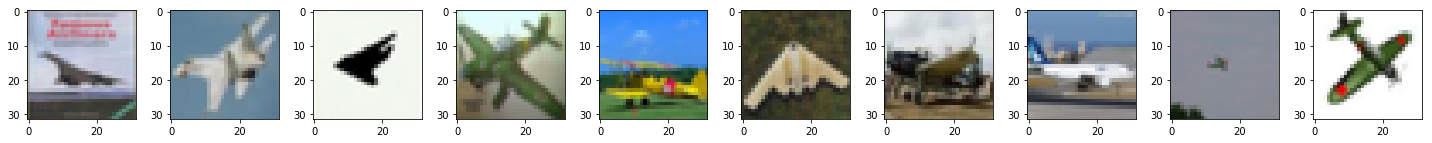

In [42]:
class_ind = 0
first_group = np.where(y_test.flatten() == class_ind)[0][:10]
fig, ax = plt.subplots(1, 10, figsize=(20,3))
for i, a in enumerate(ax.flatten()):
    a.imshow(x_test[first_group[i]])
fig.tight_layout()

OK, it's airplanes! Let's see what the nnet did...

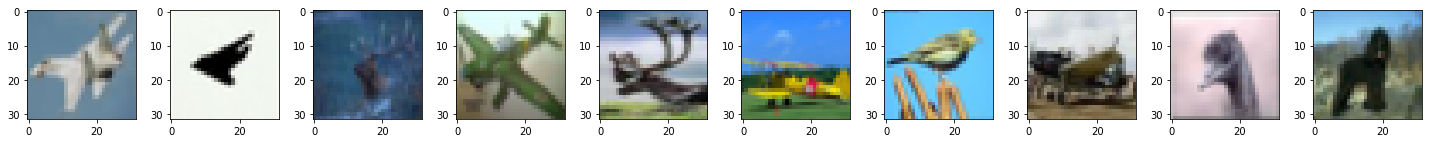

In [43]:
first_group = np.where(pred.flatten() == class_ind)[0][:10]
fig, ax = plt.subplots(1, 10, figsize=(20,3))
for i, a in enumerate(ax.flatten()):
    a.imshow(x_test[first_group[i]])
fig.tight_layout()

Let's see some examples that it got wrong.

In [44]:
print(np.mean(pred != y_test.flatten()))
inds = np.where(pred != y_test.flatten())[0]
print(inds[:20], '\n', pred[inds][:20], '\n', y_test.flatten()[inds][:20])

0.3468
[ 3  6 12 15 22 24 25 26 32 33 35 40 47 50 52 57 58 59 61 63] 
 [8 9 3 6 0 4 4 3 6 6 8 0 8 2 7 3 6 3 5 8] 
 [0 1 5 8 4 5 2 4 4 5 2 4 9 9 0 7 4 6 3 3]


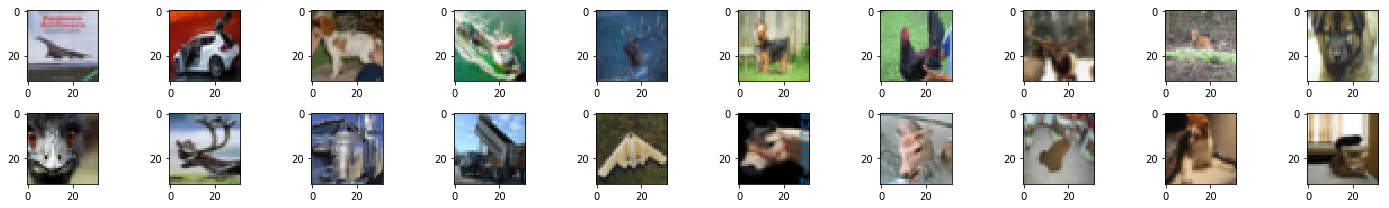

In [45]:
fig, ax = plt.subplots(2, 10, figsize=(20,3))
for i, a in enumerate(ax.flatten()):
    a.imshow(x_test[inds[i]])
fig.tight_layout()